# Analysis using only the program characteristics

In [2]:
import pandas as pd
import pyreadstat
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import shap
import numpy as np

In [4]:
data = pd.read_stata("C:/Users/ASUS/Desktop/Harvard/leila_survey/complete_codes/data/V1_qualflags_analysis2_ML.dta")
df, meta = pyreadstat.read_dta("C:/Users/ASUS/Desktop/Harvard/leila_survey/complete_codes/data/V1_qualflags_analysis2_ML.dta")
    
variable_labels = dict(zip(data.columns, meta.column_labels))

In [6]:
relevant_program_data_dummies = pd.get_dummies(data)

In [8]:
# Replace characters in columns that don't work for modeling

new_cols = []
for item in relevant_program_data_dummies.columns:
    if '>' in item:
       item = item.replace('>', 'greater')
    if '<' in item:
       item = item.replace('<', 'less')
    if ',' in item:
       item = item.replace(',', '_')
    new_cols.append(item)

relevant_program_data_dummies.columns = new_cols
relevant_program_data_dummies.head()

,f_size_n,f_hq_na,f_mne,f_mne_us,f_mne_nonus,f_sub_asia,f_sub_africa,f_sub_northamerica,f_sub_southamerica,f_sub_europe,...,clusplot2_No Skill Gap,sk_gapcertainty_Not confident at all,sk_gapcertainty_Not very confident,sk_gapcertainty_Somewhat confident,sk_gapcertainty_Very confident,sk_gapcertainty_Completely certain,tr_clusplot2_Digital+Cognitive,tr_clusplot2_Everything,tr_clusplot2_Soft,tr_clusplot2_Digital+Soft
0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,False,False,False,False,False,True,False,False,False
1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,True,False,False,False
2,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,False,False,True,False,False,False,False,False,True
3,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,True,False
4,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,True,False


In [10]:
relevant_program_data_dummies = relevant_program_data_dummies.replace({True: 1, False: 0})
relevant_program_data_dummies.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8268\3066608497.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relevant_program_data_dummies = relevant_program_data_dummies.replace({True: 1, False: 0})


,f_size_n,f_hq_na,f_mne,f_mne_us,f_mne_nonus,f_sub_asia,f_sub_africa,f_sub_northamerica,f_sub_southamerica,f_sub_europe,...,clusplot2_No Skill Gap,sk_gapcertainty_Not confident at all,sk_gapcertainty_Not very confident,sk_gapcertainty_Somewhat confident,sk_gapcertainty_Very confident,sk_gapcertainty_Completely certain,tr_clusplot2_Digital+Cognitive,tr_clusplot2_Everything,tr_clusplot2_Soft,tr_clusplot2_Digital+Soft
0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,0,0
2,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,1
3,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0
4,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [16]:
outcomes = []
for out in list(data['program']):
    if out == 'Reskilling':
        outcomes.append(1)
    else:
        outcomes.append(0)

In [14]:
variables = [
    'p_participated_2023', 'p_mandavolunt', 'p_year_start', 'p_year_end', 'p_ongoing', 
    'p_program_length', 'p_hourstrained', 'p_duration', 'p_comphours', 'p_otjactivities', 
    'p_cost', 'p_adequatefund', 'p_adequatefunddummy', 'p_fund_gov', 'p_fund_org', 
    'p_fund_wrk', 'p_fund_union', 'p_fund_other', 'p_advocacy', 'p_advocacy_hier', 
    'p_responsibility', 'p_responsibility_hier', 'p_application', 'p_selection', 
    'p_criteria_jobtitle', 'p_criteria_tenure', 'p_criteria_qualifications', 
    'p_criteria_assmskills', 'p_criteria_assmsmotivation', 'p_criteria_managerrec', 
    'p_criteria_other', 'p_targetemp_c', 'p_targetemp_bul', 'p_targetemp_mm', 
    'p_targetemp_emp', 'p_targetfunc_leg', 'p_targetfunc_hr', 'p_targetfunc_adm', 
    'p_targetfunc_it', 'p_targetfunc_op', 'p_targetfunc_mrksal', 'p_targetfunc_rd', 
    'p_targetfunc_accfin', 'p_targetfunc_cust', 'p_difloc', 'p_difstand', 'p_eligibility', 
    'p_part', 'p_part_exp', 'dd_pilot_length', 'dd_pilot_dummy', 'dd_pilot_ct', 
    'dd_pilot_over', 'dd_design_board', 'dd_design_c', 'dd_design_hr', 'dd_design_bul', 
    'dd_design_mm', 'dd_design_emp', 'dd_design_union', 'dd_design_ia', 'dd_external', 
    'dd_extdesign_ta', 'dd_extdesign_gov', 'dd_extdesign_acad', 'dd_extdesign_lsshelf', 
    'dd_extdesign_custom', 'dd_extdesign_all', 'dd_delivery', 'mot_mgragg', 'mot_wrkagg', 
    'inc_mgr_fin', 'inc_mgr_nofin', 'inc_mgr_rec', 'inc_mgr_intrin', 'inc_mgr_none', 
    'inc_mgr_all', 'inc_wrk_career', 'inc_wrk_risk', 'inc_wrk_fin', 'inc_wrk_nofin', 
    'inc_wrk_cert', 'inc_wrk_rec', 'inc_wrk_strat', 'inc_wrk_job', 'inc_wrk_all', 
    'exp_participation', 'p_finassessment', 'k_track_numberppl', 'k_track_hours', 
    'k_track_attract', 'k_track_completion', 'k_track_changeskill', 'k_track_changecareer', 
    'k_track_otherHR', 'k_track_busoutcomes', 'k_track_benefitstraining', 'k_track_other', 
    'k_track_none', 'k_review_BoD', 'k_review_c', 'k_review_hr', 'k_review_bul', 
    'k_review_mm', 'k_review_emp', 'k_review_union', 'k_review_ia', 'k_review_other', 
    'k_reviewcombined_c', 'k_reviewcombined_hr', 'k_reviewcombined_others', 'k_freq', 
    'mot_mgragg', 'mot_wrkagg', 'inc_mgr_fin', 'inc_mgr_nofin', 'inc_mgr_rec', 
    'inc_mgr_intrin', 'inc_mgr_none', 'inc_mgr_all', 'inc_wrk_career', 'inc_wrk_risk', 
    'inc_wrk_fin', 'inc_wrk_nofin', 'inc_wrk_cert', 'inc_wrk_rec', 'inc_wrk_strat', 
    'inc_wrk_job', 'inc_wrk_all', 'exp_participation', 'p_finassessment', 
    'k_track_numberppl', 'k_track_hours', 'k_track_attract', 'k_track_completion', 
    'k_track_changeskill', 'k_track_changecareer', 'k_track_otherHR', 'k_track_busoutcomes', 
    'k_track_benefitstraining', 'k_track_other', 'k_track_none', 'k_review_BoD', 
    'k_review_c', 'k_review_hr', 'k_review_bul', 'k_review_mm', 'k_review_emp', 
    'k_review_union', 'k_review_ia', 'k_review_other', 'k_reviewcombined_c', 
    'k_reviewcombined_hr', 'k_reviewcombined_others', 'k_freq'
]
relevant_program_data_dummies = relevant_program_data_dummies[relevant_program_data_dummies.columns.intersection(variables)]
relevant_program_data_dummies.head()

,p_ongoing,p_program_length,p_fund_gov,p_fund_org,p_fund_wrk,p_fund_union,p_fund_other,p_criteria_jobtitle,p_criteria_tenure,p_criteria_qualifications,...,k_review_hr,k_review_bul,k_review_mm,k_review_emp,k_review_union,k_review_ia,k_review_other,k_reviewcombined_c,k_reviewcombined_hr,k_reviewcombined_others
0,1.0,4.0,0.0,100.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1.0,4.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,NaN,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,2.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,1.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,4.0,0.0,0.0,100.0,0.0,0.0,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [20]:
X_train_val, X_test, y_train_val, y_test = train_test_split(relevant_program_data_dummies, outcomes, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [24]:
def model_loop(X,y):
    """
    Train a new model with inputs X, y
    Return feature importances and the model object
    """
    xgb_mod_loop = xgb.XGBClassifier(random_state = 42)
    xgb_mod_loop.fit(X, y)

    feature_imps = list(zip(X.columns, xgb_mod_loop.feature_importances_))
    
    return feature_imps, xgb_mod_loop

def get_remove_features(feature_imps):
    """
    Removes all 0 importance features or the lowest importance feature

    feature_imps: Zipped list of feature importances and column names
    Return: Features to remove
    """
    one_list = [i[0] for i in feature_imps if i[1] == 1]
    if one_list:
        print(one_list)
        return one_list
    #zero_list = [i[0] for i in feature_imps if i[1] == 0]
    #if zero_list:
    #    print(zero_list)
    #    return zero_list
    else:
        feat_to_remove = sorted(feature_imps, key = lambda x:x[1], reverse=True)[0][0]
        print(feat_to_remove)
        return [feat_to_remove]
    
def remove_features(X, feat_list):
    new_cols = [i for i in X_train.columns if i not in feat_list]
    return X[new_cols]

In [26]:
auc_score = 1
loop_num = 0
AUC_lim = 1
best_auc = 0

auc_list = []
num_features = []

while auc_score >= AUC_lim:
    feature_imps, mod = model_loop(X_train, y_train)

    feats_to_remove = get_remove_features(feature_imps)

    y_pred_proba = mod.predict_proba(X_val)[:, 1]  # Assuming binary classification
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    auc_score = roc_auc_score(y_val, y_pred_proba)
    auc_list.append(auc_score)

    num_features.append(len(X_train.columns))
    
    X_train = remove_features(X_train, feats_to_remove)
    X_val = remove_features(X_val, feats_to_remove)

    # What features were removed before best model???

    #print(f"Features removed at loop {loop_num}")
    #print(feats_to_remove)
    print(f"AUC score at loop {loop_num}: {auc_score}")
    print(f"Top feature imps at loop {loop_num}: {sorted(feature_imps, key = lambda x:x[1], reverse=True)[0:3]}")
    if auc_score >= best_auc:
        best_auc=auc_score
        print(f"Updated best auc score to: {best_auc} with {len(X_train.columns)} features")
    loop_num += 1
    if len(X_train.columns) == 0:
        print("All columns removed")
        break

inc_mgr_none
AUC score at loop 0: 0.7705670272041953
Top feature imps at loop 0: [('inc_mgr_none', 0.046627786), ('p_program_length', 0.04656346), ('k_review_BoD', 0.032059547)]
Updated best auc score to: 0.7705670272041953 with 65 features


In [28]:
# XGBoost Model initiation
xgb_mod = xgb.XGBClassifier(random_state=42)
xgb_mod.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [30]:
main_model_feats = list(zip(X_train.columns, xgb_mod.feature_importances_))
most_imp = sorted(main_model_feats, key = lambda x:x[1], reverse=True)[0:10]
print(most_imp)

[('p_program_length', 0.047279578), ('inc_wrk_job', 0.036014877), ('k_review_BoD', 0.032394897), ('p_criteria_jobtitle', 0.03148218), ('p_fund_union', 0.030896103), ('inc_wrk_fin', 0.026832528), ('dd_design_hr', 0.026477225), ('dd_design_bul', 0.026151728), ('k_track_otherHR', 0.025083616), ('inc_wrk_rec', 0.024911145)]


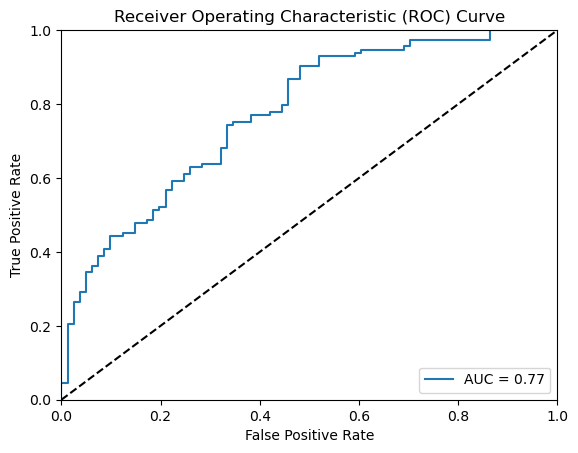

In [32]:
# Get the results of the modeling accuracy

y_pred_proba = xgb_mod.predict_proba(X_val)[:, 1]  # Assuming binary classification

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc_score = roc_auc_score(y_val, y_pred_proba)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [36]:
## Extracting the labels from the dta file and add those labels to the dictionary created in the next code block
def add_unique_keys(main_dict, other_dict):
    for key, value in other_dict.items():
        # Add the key-value pair to the main dictionary if the key does not already exist
        if key not in main_dict:
            main_dict[key] = value

# Delete Nones
def remove_none_from_list(input_list):
    return [item for item in input_list if item is not None]

In [38]:
label_mapping = {
    'roi4': 'Negative ROI',
    'roi_yes': 'ROI Measured',
    'ecp_extredeployment': 'External Redeployment',
    'p_effect_reverse': 'Program Effectiveness',
    'evp_network': 'Cross-departmental Networks',
    'roi5': 'Positive ROI',
    'sum_tr_sk': 'Sum of Trained Skills',
    'sha_b_sk_n_digital': 'Share Needed Digital Skills',
    'stat_government': 'Help Org Use Gov Subsidy',
    'ecp_intredeployment': 'Internal Redeployment',
    'stat_csr': 'Fulfilling CSR Requirement',
    'reason_dei': 'Reason DEI',
    'sk_selected': 'Total Nr skills needed',
    'stand2': 'Mix Standardization customization',
    'f_union_1 - 25%': 'Union Share 1-25%',
    'inc_mgr_nofin': 'Manager: Non-financial Incentive',
    'invest_cont': 'Continued Investment',
    'p_fund_gov': 'Funded by Government',
    'f_medium': 'Medium Firm Size (100-999)',
    'roi2': 'Not yet but intend to calculate ROI',
    'roi3': 'Tried to but unable to',
    'roi1': 'No attempt to calculate',
    'p_eligibility': 'Participation Eligibility',
    'p_targetfunc_it_Not Selected': 'Target Function: IT not selected',
    'p_cont_investment_Very likely': 'Cont. Investment Very Likely',
    'p_adv_hr': 'Advocate HR',
    'p_participated_2023_1000 - 9999': 'Participated in 2023 (1000 - 9999)',
    'p_program_length': 'Program Length (Years)',
    'p_fund_org': 'Funded by Org',
    'p_criteria_jobtitle': 'Selection Criteria: Job Title',
    'p_criteria_assmskills': 'Selection Criteria: Assessment of Skills',
    'p_target_emp': 'Target Group: Employees',
    'p_challenge_progcompl': 'Challenge: Program Completion',
    'p_year_end_2023': 'Program End: 2023',
    'p_part': 'Number of participants',
    'p_fund_wrk': 'Funded by Worker',
    'sha_b_sk_n_soft': 'Needed share soft skill',
    'sha_b_sk_n_man': 'Needed share mgmt skill',
    'p_part_exp': 'Expected Participation',
    'tot_kpi_tracked': 'Total Nr of KPIs'
}
add_unique_keys(label_mapping,variable_labels)
for key, value in label_mapping.items():
    if value is None:
        label_mapping[key] = key

In [40]:
# Map the feature names to their corresponding labels, same as in the xgboost plot
mapped_feature_names = [label_mapping.get(feature, feature) for feature in X_train.columns]
mapped_feature_names = remove_none_from_list(mapped_feature_names)
mapped_feature_names
len(mapped_feature_names)

65

In [42]:
# Assuming X_train and X_val contain your training and validation data
explainer = shap.Explainer(xgb_mod.predict, X_train)
# Generate SHAP values
shap_values = explainer.shap_values(X_val)
#shap_values = explainer(X_val).values

PermutationExplainer explainer: 195it [01:40,  1.86it/s]                         


## Top 10 features

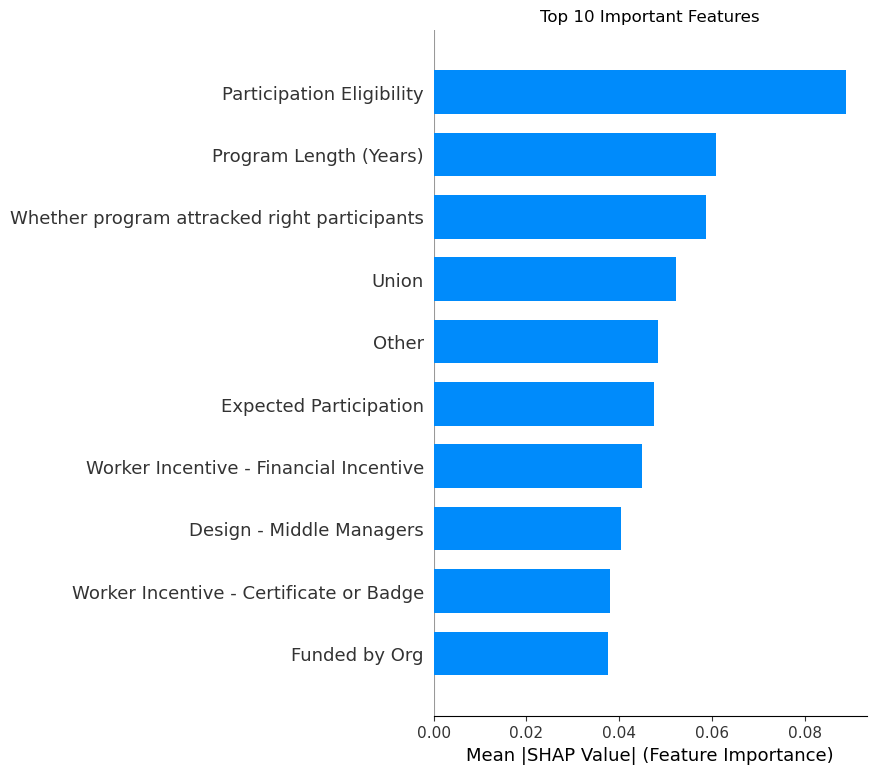

In [45]:
importances = np.abs(shap_values).mean(0)

top_10_indices = np.argsort(importances)[-10:]

top_10_indices = top_10_indices[np.argsort(importances[top_10_indices])]

top_10_features=[]
for i in top_10_indices:
    a=mapped_feature_names[i]
    top_10_features.append(a)

# Plot SHAP summary bar plot for top 10 features
shap.summary_plot(shap_values[:, top_10_indices], feature_names=top_10_features, plot_type="bar", show=False)

plt.gcf().set_size_inches(10, 8)
plt.title("Top 10 Important Features")
plt.xlabel("Mean |SHAP Value| (Feature Importance)")
plt.show()

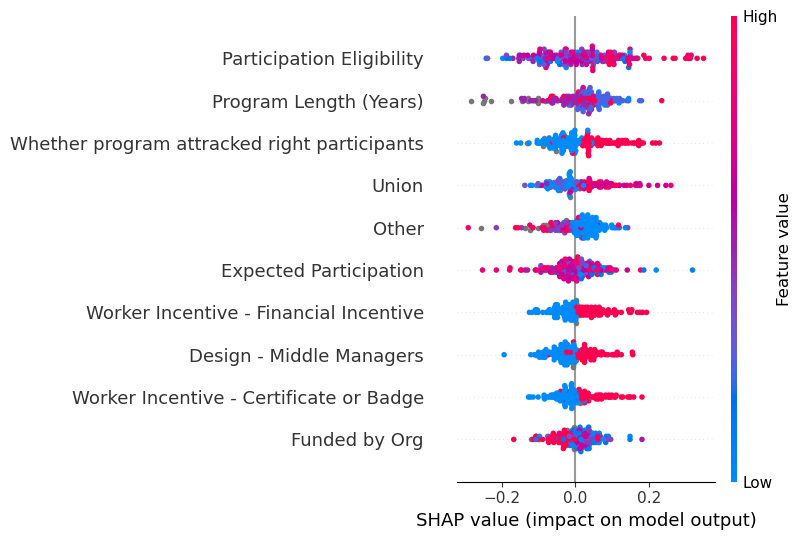

In [47]:
# Plot the SHAP summary plot using the mapped feature names
shap.summary_plot(shap_values[:, top_10_indices],X_val.iloc[:, top_10_indices], feature_names=top_10_features)

## Top 20 features

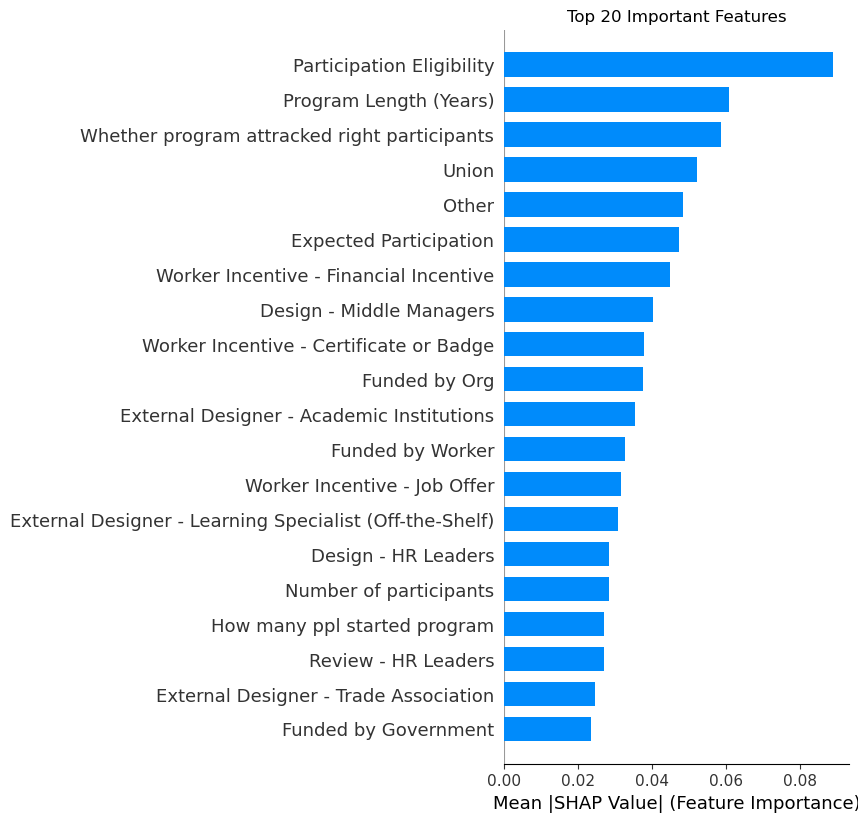

In [49]:
importances = np.abs(shap_values).mean(0)

top_20_indices = np.argsort(importances)[-20:]

top_20_indices = top_20_indices[np.argsort(importances[top_20_indices])]

top_20_features=[]
for i in top_20_indices:
    a=mapped_feature_names[i]
    top_20_features.append(a)

# Plot SHAP summary bar plot for top 10 features
shap.summary_plot(shap_values[:, top_20_indices], feature_names=top_20_features, plot_type="bar", show=False)

plt.gcf().set_size_inches(10, 8)
plt.title("Top 20 Important Features")
plt.xlabel("Mean |SHAP Value| (Feature Importance)")
plt.show()

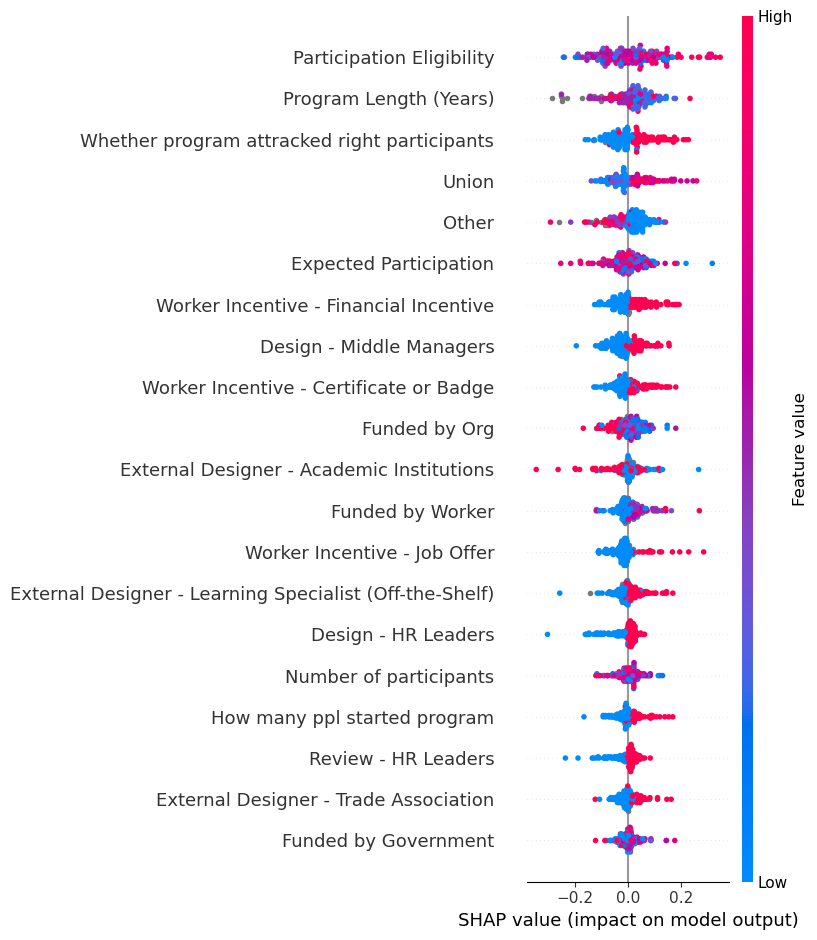

In [54]:
# Plot the SHAP summary plot using the mapped feature names
shap.summary_plot(shap_values[:, top_20_indices], X_val.iloc[:, top_20_indices], feature_names=top_20_features)